In [228]:
import numpy as np
import pandas as pd
import datetime
from scipy.optimize import minimize
import yfinance as yf
import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
sns.set()
params = {'figure.figsize': (20,10)}
plt.rcParams.update(params)


In [229]:
def zero_coupon(tau, r0, kappa, theta, sigma, model):
    
    B = (1 - np.exp(-kappa * tau)) / kappa
    A = (theta - sigma ** 2 / (2 * kappa ** 2)) * \
            (B - tau) - (sigma ** 2 / (4 * kappa)) * B ** 2
    r_ = np.repeat(r0, len(A))
    p = np.exp(A - B* r_)
    return p

def liborRates(tau, p, mat):
    p = np.interp(mat, tau, p)
    return 100 * (1. / p - 1) / mat
   
def objFunc1(params, tau, LIBOR, model):
    # unpack params
    r0 = params[0]
    kappa = params[1]
    theta = params[2]
    sigma = params[3]
    p = zero_coupon(tau, r0, kappa, theta, sigma, model)
    L = liborRates(tau, p, LIBOR[:,0])
    rel2 = (L - LIBOR[:,1]) / LIBOR[:,1]
    mae = np.sum(rel2**2)
    return mae

def calibration(fun, param_0, tau, LIBOR, model):
    opt = {'maxiter':10000, 'maxfev':5e3}
    sol = minimize(objFunc1, params1, args = (tau, LIBOR, model), method='Nelder-Mead', options=opt)
    print(sol.message)
    par = np.array(sol.x)
    print('parameters = ' + str(par))
    r_star = par[0]
    kappa_star = par[1]
    theta_star = par[2]
    sigma_star = par[3]
    return r_star,kappa_star,theta_star,sigma_star


## data

In [220]:
df = pd.read_csv('swapLiborData.csv')
def days_since_jan_1_1900_to_datetime(d):
    return datetime.datetime(1900,1,1) + datetime.timedelta(days=d-2)
df["Date"] = df["Date"].apply(days_since_jan_1_1900_to_datetime)
df.set_index("Date",drop=True, inplace=True)

In [221]:
LIBOR_df = df.iloc[:,2:3]
LIBOR = np.insert(LIBOR_df.values, 0, np.array([3/12]), 0).T

## Initial parameters

In [222]:
tau = np.arange(0, 30 + 1/12, 1/12)

# initial starting point
# r0 = 0.25 kappa0 = 5 theta0 = 0.2 sigma0 = 0.1
params1 = np.array([0.25, 5, 0.2, 0.1]);
model = 'VASEICK'

   ## VASICEK Parameters After Calibration

In [223]:
r_star,kappa_star,theta_star,sigma_star = calibration(objFunc1, params1, tau, LIBOR[:,[0,1]], model) 


Optimization terminated successfully.
parameters = [-0.40871493 10.82511332  0.21889089  0.14392154]


# getting historic data

In [235]:
price = yf.download("^STOXX50E", start = "2016-10-03", end = "2020-12-3")['Adj Close'].reset_index()
fx_rate = pd.read_csv('fxrate.csv').fillna(method = 'bfill').fillna(method = 'ffill')
fx_rate['Date'] = fx_rate['Date'].astype('datetime64[ns]')
weekday = pd.bdate_range('2016-10-01', '2020-12-3')
fx_rate = fx_rate[fx_rate['Date'].isin(weekday)]
fx_rate = fx_rate.loc[(fx_rate['Date'] >= "2016-11-29") & (fx_rate['Date'] <= "2020-12-3")]
libor = pd.read_csv('3-month-libor.csv').fillna(method = 'bfill').fillna(method = 'ffill')
libor['Date'] = libor['Date'].astype('datetime64[ns]')
libor = libor.sort_values(by = ['Date'])
libor=libor.iloc[-400:-1]

[*********************100%***********************]  1 of 1 completed


# GETTING DRIFT AND VOLATILITY

In [236]:
corr = np.corrcoef(fx_rate['Rate'], price['Adj Close'])[0][1]
mean_old = np.sum(np.log(price['Adj Close']/price['Adj Close'].shift(1)))/len(price['Date'])
vol_fx = fx_rate['Rate'].std()


# INCORPORATING CORRELATION BETWEEN STOCK AND FX RATE

In [226]:
mu = x_bar - corr * vol * vol_fx - 0.5 * vol ** 2
sigma= vol_fx    
print(mu,sigma)

-0.00214980214363078 0.0461918961948765


# SIMULATING THE ASSET PRICE

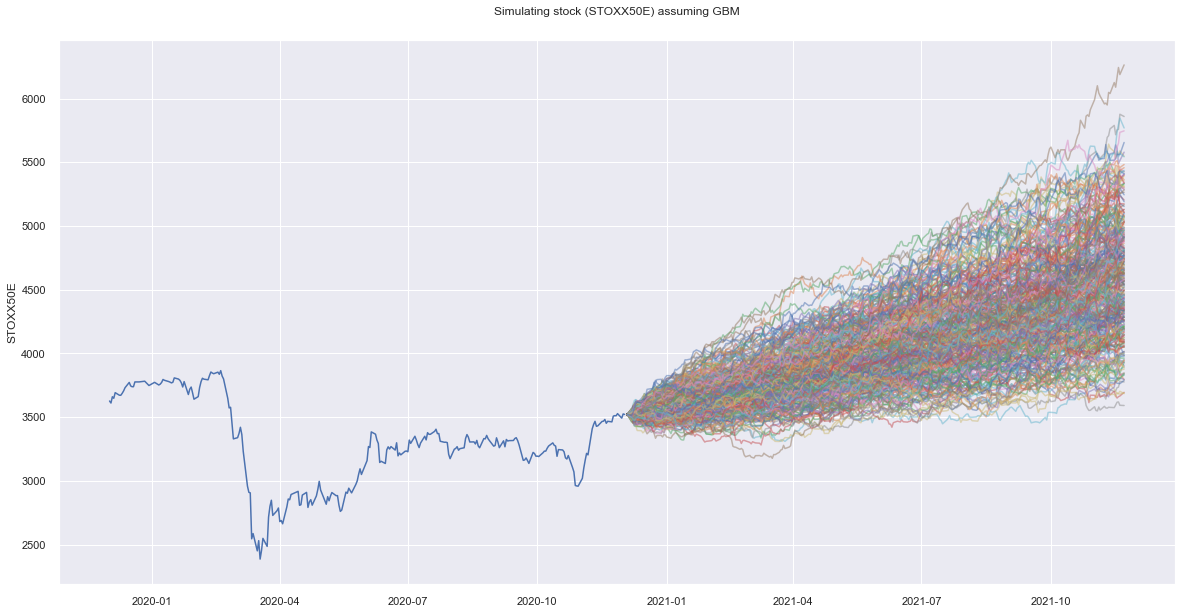

In [241]:
def GBM(seed, price, mu, sigma): 
        N = 252
        So = price['Adj Close'].iloc[-1]
        n_simulations = 75
        GBM_avg = np.zeros((n_simulations, N))
        for i in range(n_simulations):
            W =np.cumsum(np.random.normal(0., 1., int(N))*np.sqrt(1))
            sim = [So if i==0 else So*np.exp((mu - 0.5 * sigma**2) * np.ones((N + 1))[i] + sigma * W[i-1]) for i in range(0,int(N+1))][:-1]
            GBM_avg[i] = sim
        gbm_avg = GBM_avg.mean(axis = 0) 
        drg = pd.date_range('2020-12-4', periods=len(gbm_avg), freq='B')
        price_gbm = pd.DataFrame({ 'Date': drg, 'Close': gbm_avg}) 
        return price_gbm

def stock_simulator(n):
    plt.title('Simulating stock (STOXX50E) assuming GBM')
    plt.ylabel("STOXX50E")
    plt.plot(price['Date'][-252:], price['Adj Close'][-252:], label = "STOXX50E historical price")
    for i in range(n):
        seed = np.random.randint(10001)
        price_gbm = GBM(seed, price, x_bar, vol)
        plt.plot(price_gbm['Date'], price_gbm['Close'], alpha = 0.50)

stock_simulator(350)

# SIMULATING INTEREST RATES

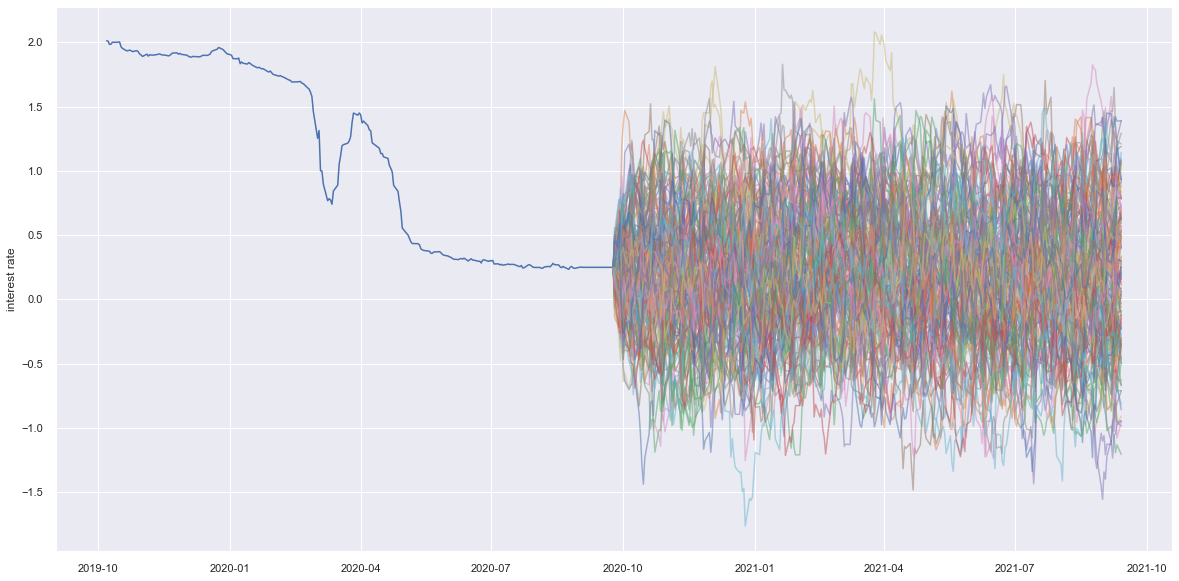

In [242]:
def Vasicek( df, r0, K, drift, sigma, T, N, seed):    
    rates = [r0]
    random.seed(seed)
    for i in range(N):
        dr = K*(drift-rates[-1])* T/float(N)   + sigma*np.random.normal()
        rates.append(dr+rates[-1])
    rng = pd.date_range(df['Date'].iloc[-1], periods= N + 1 , freq='B')
    return pd.DataFrame({ 'Date': rng, '3M': rates}) 
   
def vasicekSimulator(n):
    plt.ylabel("interest rate")
    plt.plot(libor['Date'][-252:], libor['3M'][-252:], label = "Historical")
    for i in range(n):
        seed = np.random.randint(1001)
        libor_pred = Vasicek(libor, libor['3M'].iloc[-1], kappa_star, theta_star, sigma_star, 1, n_days, seed)
        plt.plot(libor_pred['Date'], libor_pred['3M'], alpha = 0.5)
    plt.show()
        
vasicekSimulator(150)


# Option Pricing Simulator


In [243]:
def option_simulator(n, strike_1, strike_2):
    option_prices = np.zeros((n))
    index = 0
    T = 252
    delta = 69
    for i in range(n):
        seed = np.random.randint(1001)
        libor_pred = Vasicek(libor, libor['3M'].iloc[-1], kappa_star, theta_star, sigma_star, 1, 252, seed)
        price_gbm = GBM(seed, price, x_bar, vol)
        rates = libor_pred['3M']/100.0    
        discount_factor = 1/(1 + np.mean(rates))
        forward_rate = T/delta * (1/(1 + np.mean(rates[:-delta])  )/ discount_factor - 1)           
        ST = price_gbm['Close'].iloc[-1]
        S0 = price_gbm['Close'].iloc[0]
        option_payoff = max(0, (ST/S0 - strike_1) * (rates.iloc[-delta]/forward_rate - strike_2))
        option_price = discount_factor * option_payoff 
        option_prices[index] = option_price
        index += 1   
    print ("k: " + str(strike_1) + ", k': " + str(strike_2) + "\n")
    print ("Option Price (mean): ", np.mean(option_prices))
    print ("Option Price (standard error): ", np.std(option_prices))



In [246]:
option_simulator( 10000, 1.0, 1.0)


k: 1.0, k': 1.0

Option Price (mean):  0.9895284253407175
Option Price (standard error):  15.704804774511986


In [247]:
option_simulator( 10000, 0.1, 0.1)


k: 0.1, k': 0.1

Option Price (mean):  7.3235585343366765
Option Price (standard error):  179.59811110468914
